## 1. Load dataset and prepare data

In [1]:
# load data
import pandas as pd
import numpy as np

data= pd.read_csv("train_valid.csv")
test = pd.read_csv("test.csv")

In [2]:
data.shape

(134, 22)

In [3]:
# select predictors
X = data.loc[:,'View':'cou_score']
X = X.drop(['type'], axis=1) # Drop type variable since it is not different among records

In [4]:
X.head()

,View,Like,Dislike,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity,neg_score,neu_score,pos_score,cou_score
0,3.486371e+08,2353239.0,130665.0,0.889,0.496,0.091,0.259,0.0,0.252,0.544,86.0,180522.0,84,0.087915,0.718298,0.193809,0.153996
1,6.627059e+08,8520437.0,261554.0,0.585,0.520,0.071,0.124,0.0,0.131,0.129,160.0,218147.0,88,0.009598,0.754530,0.027538,0.016436
2,1.130104e+09,11480794.0,431209.0,0.754,0.449,0.109,0.033,0.0,0.552,0.357,77.0,198973.0,85,0.080420,0.663640,0.215960,0.142170
3,2.202959e+08,3657786.0,175288.0,0.835,0.626,0.125,0.059,0.0,0.396,0.350,91.0,217925.0,83,0.058980,0.771120,0.169900,0.112620
4,6.805167e+08,4054252.0,117924.0,0.672,0.655,0.031,0.036,0.0,0.117,0.556,135.0,201240.0,81,0.077653,0.683429,0.238918,0.211324


In [5]:
# select target
y=data[['Millions']]
y.head()

,Millions
0,79.0
1,20.9
2,79.0
3,79.0
4,67.4


## 2. Feature Selection

Correlatiion Between Variables

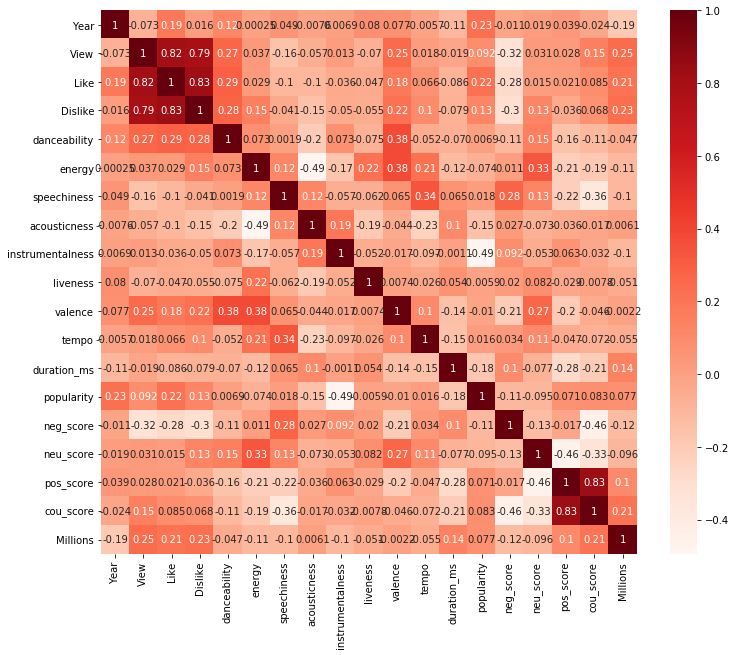

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Selecting highly correlated features

In [7]:
#Correlation with output variable
cor_target = abs(cor["Millions"])
relevant_features = cor_target[cor_target>0.1]
relevant_features

Year                0.190312
View                0.246744
Like                0.208541
Dislike             0.234133
energy              0.110044
speechiness         0.102878
instrumentalness    0.103213
duration_ms         0.137954
neg_score           0.123657
pos_score           0.101660
cou_score           0.208996
Millions            1.000000
Name: Millions, dtype: float64

Forward Selection

In [8]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

sfs = SFS(LinearRegression(),
           k_features=11,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 10)

sfs.fit(X, y)
sfs.k_feature_names_

('Like',
 'energy',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'valence',
 'tempo',
 'popularity',
 'neg_score',
 'pos_score',
 'cou_score')

Backward selection

In [9]:
sbs = SFS(LinearRegression(), 
          k_features=11, 
          forward=False, 
          floating=False,
          scoring = 'r2',
          cv=10)
sbs.fit(X, y)
sbs.k_feature_names_

('Like',
 'energy',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'valence',
 'tempo',
 'popularity',
 'neg_score',
 'pos_score',
 'cou_score')

Select predictors variables after doing feature selection

In [10]:
X = X[['View', 'Dislike', 'danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 
       'duration_ms', 'neg_score', 'pos_score', 'cou_score']]

In [11]:
X.head()

,View,Dislike,danceability,energy,acousticness,instrumentalness,liveness,duration_ms,neg_score,pos_score,cou_score
0,3.486371e+08,130665.0,0.889,0.496,0.259,0.0,0.252,180522.0,0.087915,0.193809,0.153996
1,6.627059e+08,261554.0,0.585,0.520,0.124,0.0,0.131,218147.0,0.009598,0.027538,0.016436
2,1.130104e+09,431209.0,0.754,0.449,0.033,0.0,0.552,198973.0,0.080420,0.215960,0.142170
3,2.202959e+08,175288.0,0.835,0.626,0.059,0.0,0.396,217925.0,0.058980,0.169900,0.112620
4,6.805167e+08,117924.0,0.672,0.655,0.036,0.0,0.117,201240.0,0.077653,0.238918,0.211324


In [12]:
X_array = np.array(X)
y_array = np.array(y)

In [13]:
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

def model_use_LOOCV(md):
    ytests = []
    ypreds = []
    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X_array[train_idx], X_array[test_idx] #requires arrays
        y_train, y_test = y_array[train_idx], y_array[test_idx]
    
        model = md
        model.fit(X = X_train, y = y_train.ravel()) 
        y_pred = model.predict(X_test)
                
        ytests += list(y_test)
        ypreds += list(y_pred)
    
    ms_error = metrics.mean_squared_error(ytests, ypreds, squared=False)
        
    print("RMSE: {:.5f}".format(ms_error))

## 3. Decision trees using LOOCV

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer,r2_score
from sklearn.metrics import mean_squared_error
# from sklearn import model_selection

In [15]:
# initialize the dtree algorithm
dtree1=DecisionTreeRegressor(random_state=50)
# use friedman_mse criterion for the change
dtree2=DecisionTreeRegressor(random_state=50, criterion ='friedman_mse')
# change the depth of tree
dtree3=DecisionTreeRegressor(random_state=50, max_depth = 8)

## 4. Random Forest Using LOOCV

In [16]:
from sklearn.ensemble import RandomForestRegressor

In [17]:
# create a random forest with 100 or 50 or 10  trees
rforest1=RandomForestRegressor(random_state=50,n_estimators=10)
rforest2=RandomForestRegressor(random_state=50,n_estimators=50)
rforest3=RandomForestRegressor(random_state=50,n_estimators=100)

# create a random forest with 10, 100 trees with max_depth of 8
rforest4=RandomForestRegressor(random_state=50,n_estimators=10, max_depth = 5)
rforest5=RandomForestRegressor(random_state=50,n_estimators=100, max_depth = 8)

## 5. K-Nearest Neighbor Model

In [18]:
from sklearn import neighbors

In [19]:
# k-nearest neighbors model 

# run the following to find best k from 1-50 for the model
# for K in range(50):
#     K = K+1
#     model = neighbors.KNeighborsRegressor(n_neighbors = K)
#     print('RMSE value for k= ' , K )
#     model_use_LOOCV(model)

knn1 = neighbors.KNeighborsRegressor(n_neighbors = 45)

## 4. Lasso Regression Using LOOCV

In [20]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [21]:
lasso1 = Lasso()
lasso2 = Lasso(alpha=0.3, normalize=True, max_iter=30)
lasso3 = Lasso(alpha=0.7, normalize=True, max_iter=50)

## 6. Ridge Regression Uing LOOCV

In [22]:
from sklearn.linear_model import Ridge

In [23]:
# ridge regression models
rr1 = Ridge(normalize=True)
rr2 = Ridge(alpha = 0.7,normalize=True)

## 7. Compare Models 

In [24]:
print("Decision Tree Model 1: ")
model_use_LOOCV(dtree1)
print("="*80)
print("Decision Tree Model 2: ")
model_use_LOOCV(dtree2)
print("="*80)
print("Decision Tree Model 3: ")
model_use_LOOCV(dtree3)
print("="*80)
print("Random Forest Model 1: ")
model_use_LOOCV(rforest1)
print("="*80)
print("Random Forest Model 2: ")
model_use_LOOCV(rforest2)
print("="*80)
print("Random Forest Model 3: ")
model_use_LOOCV(rforest3)
print("="*80)
print("Random Forest Model 4: ")
model_use_LOOCV(rforest4)
print("="*80)
print("Random Forest Model 5: ")
model_use_LOOCV(rforest5)
print("="*80)
print("K-Nearest Negibor with K = 45: ")
model_use_LOOCV(knn1)
print("="*80)
print("Lasso Regression Model 1: ")
model_use_LOOCV(lasso1)
print("="*80)
print("Lasso Regression Model 2: ")
model_use_LOOCV(lasso2)
print("="*80)
print("Lasso Regression Model 3: ")
model_use_LOOCV(lasso3)
print("="*80)
print("Ridge Regression Model 1: ")
model_use_LOOCV(rr1)
print("="*80)
print("Ridge Regression Model 2: ")
model_use_LOOCV(rr2)

Decision Tree Model 1: 
RMSE: 151.33624
Decision Tree Model 2: 
RMSE: 146.41776
Decision Tree Model 3: 
RMSE: 152.46119
Random Forest Model 1: 
RMSE: 124.98329
Random Forest Model 2: 
RMSE: 122.16177
Random Forest Model 3: 
RMSE: 122.05138
Random Forest Model 4: 
RMSE: 127.07184
Random Forest Model 5: 
RMSE: 123.33557
K-Nearest Negibor with K = 45: 
RMSE: 115.99033
Lasso Regression Model 1: 
RMSE: 116.37978
Lasso Regression Model 2: 
RMSE: 115.95587
Lasso Regression Model 3: 
RMSE: 116.20782
Ridge Regression Model 1: 
RMSE: 114.12892
Ridge Regression Model 2: 
RMSE: 114.18864


- **As Ridge Regression 1 has the smallest RMSE of 114.12892, so we will use that as the model to predict the concert sale in 2020 for artists (in test data).**

In [25]:
model = rr1

## 8. Use the final to predict the sale in 2020

In [26]:
test.head()

,Year,Artist,Song Name,View,Like,Dislike,danceability,energy,speechiness,acousticness,...,liveness,valence,tempo,type,duration_ms,popularity,neg_score,neu_score,pos_score,cou_score
0,2020,Drake,Toosie Slide,59212131.0,1370881.0,49691.0,0.787,0.673,0.158,0.256,...,0.090,0.786,111.0,audio_features,237893.0,97,0.058761,0.769391,0.171870,0.140309
1,2020,Doja Cat,Say So (Official Video),85600520.0,2206882.0,36219.0,0.777,0.658,0.054,0.077,...,0.090,0.633,110.0,audio_features,190360.0,83,0.032440,0.659060,0.308480,0.257262
2,2020,Taylor Swift,The Man (Official Video),37774922.0,1297372.0,142309.0,0.777,0.658,0.054,0.077,...,0.090,0.633,110.0,audio_features,190360.0,83,0.095333,0.653111,0.229333,0.103829
3,2020,Billie Eilish,No Time To Die (Audio),66616605.0,1964947.0,66981.0,0.380,0.219,0.036,0.917,...,0.083,0.052,74.0,audio_features,242265.0,89,0.115447,0.537021,0.347511,0.262334
4,2020,Selena Gomez,Boyfriend (Official Video),27853456.0,1107681.0,59571.0,0.811,0.512,0.170,0.218,...,0.077,0.346,92.0,audio_features,161188.0,84,0.072435,0.702913,0.202935,0.150761


In [27]:
X_pred = test[['View', 'Dislike', 'danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 
               'duration_ms', 'neg_score', 'pos_score', 'cou_score']]
#X_pred = pd.get_dummies(X_pred,drop_first=True)

In [28]:
model.fit(X, y)  #fit the model
pred = model.predict(X_pred) #make prediction on test set
# assign the columns to test data 
test["Millions"] = pred
# sort the test data predictions by sale 
test = test.sort_values(by = 'Millions', ascending = False).reset_index(drop = True)
# keep only year and artist, sale
test = test[["Year","Artist", "Millions"]]
test

,Year,Artist,Millions
0,2020,Justin Bieber,165.846166
1,2020,Billie Eilish,151.075645
2,2020,P!nk,134.351510
3,2020,BTS,127.454208
4,2020,Harry Styles,126.826318
5,2020,Maroon 5,121.643854
6,2020,Eminem,121.528973
7,2020,Justin Timberlake,121.005760
8,2020,Demi Lovato,117.320462
9,2020,twenty one pilots,117.286024


In [29]:
# save as a resulting csv file 
test.to_csv("test_results.csv", index=False)

In [30]:
#import matplotlib.pyplot as plt
df = pd.concat([data,test], ignore_index=True)
df = df[["Year","Artist", "Millions"]]
df = df.drop_duplicates()

<BarContainer object of 3 artists>

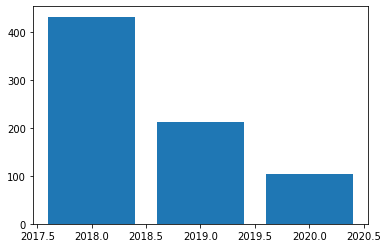

In [31]:
# example plot of Ed Sheeran sale (because of the views counted in half of year 2020)
df = df[df["Artist"]=="Ed Sheeran"]
plt.bar(df['Year'], df['Millions'])